## Lesson 1: Streaming and interruption

In some prior lessons, we showcased [streaming](https://langchain-ai.github.io/langgraph/how-tos/stream-values/). 

Here, let's cover it some more depth.

Every compiled LangGraph implements the [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/) protocol.

This provides a standard way to execute LangChain components. 
 
`stream` is one of the standard methods in this interface.

But, LangGraph supports multiple streaming modes:
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

Let's define the assist that we covered in the final lessons of Module 2.

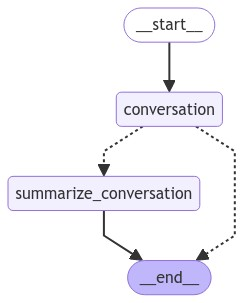

In [1]:
from typing import Annotated, List, TypedDict
from langchain_core.messages import AnyMessage
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

from IPython.display import Image, display

# We will use this model for both the conversation and the summarization
from langchain_anthropic import ChatAnthropic
model = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0) 

class State(MessagesState):
    summary: str
    
# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

def summarize_conversation(state: State):
    
    # First, we summarize the conversation
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # If a summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Add our summary to the state 
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, lets examine `stream_mode="updates"`.

Here, we can see that updates only include the `AIMessage` response after the `conversation` node is called.

In [2]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
events = graph.stream({"messages": [input_message]}, config, stream_mode="updates") 
for event in events:
    print(event)

{'conversation': {'messages': AIMessage(content="Hello Lance! It's nice to meet you. How are you doing today? Is there anything I can help you with or would you like to chat about something in particular?", response_metadata={'id': 'msg_01LXovYtwWo3d6pvPjkNL8ZW', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 12, 'output_tokens': 38}}, id='run-faa6097a-5b5c-4827-9648-0ae383755efe-0', usage_metadata={'input_tokens': 12, 'output_tokens': 38, 'total_tokens': 50})}}


Now, we can see `stream_mode="values"`.

This is the full state of the graph after the `conversation` node is called.

In [3]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="hi! I'm Lance")
events = graph.stream({"messages": [input_message]}, config, stream_mode="values") 
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! It's nice to meet you. I'm an AI assistant. How can I help you today? Is there anything specific you'd like to chat about or any questions you have?


Now, as discussed previously we can continue from the last saved checkoint in state by specifying our `thread_id`.

In [4]:
# Continue
input_message = HumanMessage(content="Tell me about the 49ers head coach")
events = graph.stream({"messages": [input_message]}, config, stream_mode="values") 
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Tell me about the 49ers head coach
================================== Ai Message ==================================

The current head coach of the San Francisco 49ers is Kyle Shanahan. Here are some key points about him:

1. Kyle Shanahan was born on December 14, 1979, in Minneapolis, Minnesota.

2. He was hired as the head coach of the San Francisco 49ers in February 2017.

3. Shanahan is the son of Mike Shanahan, a former NFL head coach who won two Super Bowls with the Denver Broncos.

4. Before becoming the 49ers' head coach, Kyle Shanahan served as an offensive coordinator for several NFL teams, including the Atlanta Falcons, Cleveland Browns, Washington Redskins, and Houston Texans.

5. He is known for his innovative offensive schemes and his ability to develop quarterbacks.

6. Under Shanahan's leadership, the 49ers reached Super Bowl LIV in 2020, where they lost to the Kansas City Chiefs.

7. He ha

We can continue! But what if we want to `stop` and re-phrase the question.

In [5]:
# Continue, but manually break
input_message = HumanMessage(content="Who were his father's top players?")

try:
    events = graph.stream({"messages": [input_message]}, config, stream_mode="values") 
    for event in events:
        event["messages"][-1].pretty_print()

except KeyboardInterrupt as e:
    print(f"KeyboardInterrupt occurred: {e}")

================================ Human Message =================================

Who were his father's top players?
KeyboardInterrupt occurred: 


Now, let's re-phrase the question and proceed!

In [6]:
# Continue, but manually break
input_message = HumanMessage(content="Who were his father's top defensive players?")
events = graph.stream({"messages": [input_message]}, config, stream_mode="values") 
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Who were his father's top defensive players?
================================== Ai Message ==================================

Mike Shanahan, Kyle's father, was primarily known for his offensive expertise, particularly his success with the running game. However, he did coach some notable defensive players during his career. Here are some of the top players from both sides of the ball that Mike Shanahan coached:

Top offensive players:
1. John Elway (QB)
2. Terrell Davis (RB)
3. Rod Smith (WR)
4. Shannon Sharpe (TE)
5. Clinton Portis (RB)

Top defensive players:
1. Champ Bailey (CB) - While with the Denver Broncos
2. Al Wilson (LB) - Broncos linebacker during Shanahan's tenure
3. Trevor Pryce (DT) - Key defensive lineman for the Broncos
4. John Lynch (S) - Played his final four NFL seasons under Shanahan in Denver
5. D.J. Williams (LB) - Drafted by Shanahan, became a solid linebacker for the Broncos

It's 

/Users/rlm/miniforge3/envs/llama2/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


What we just saw was a crude and simple form of `human-in-the-loop`! 

We manually applied `KeyboardInterrupt` on our running graph.

We updated the input. And then we proceeded, all using a common thread ID (with in-memory checkpointer) to persist the state.

Note when we use `Cancel` in LangGraph Studio, we achieve this same kind of manual interruption!

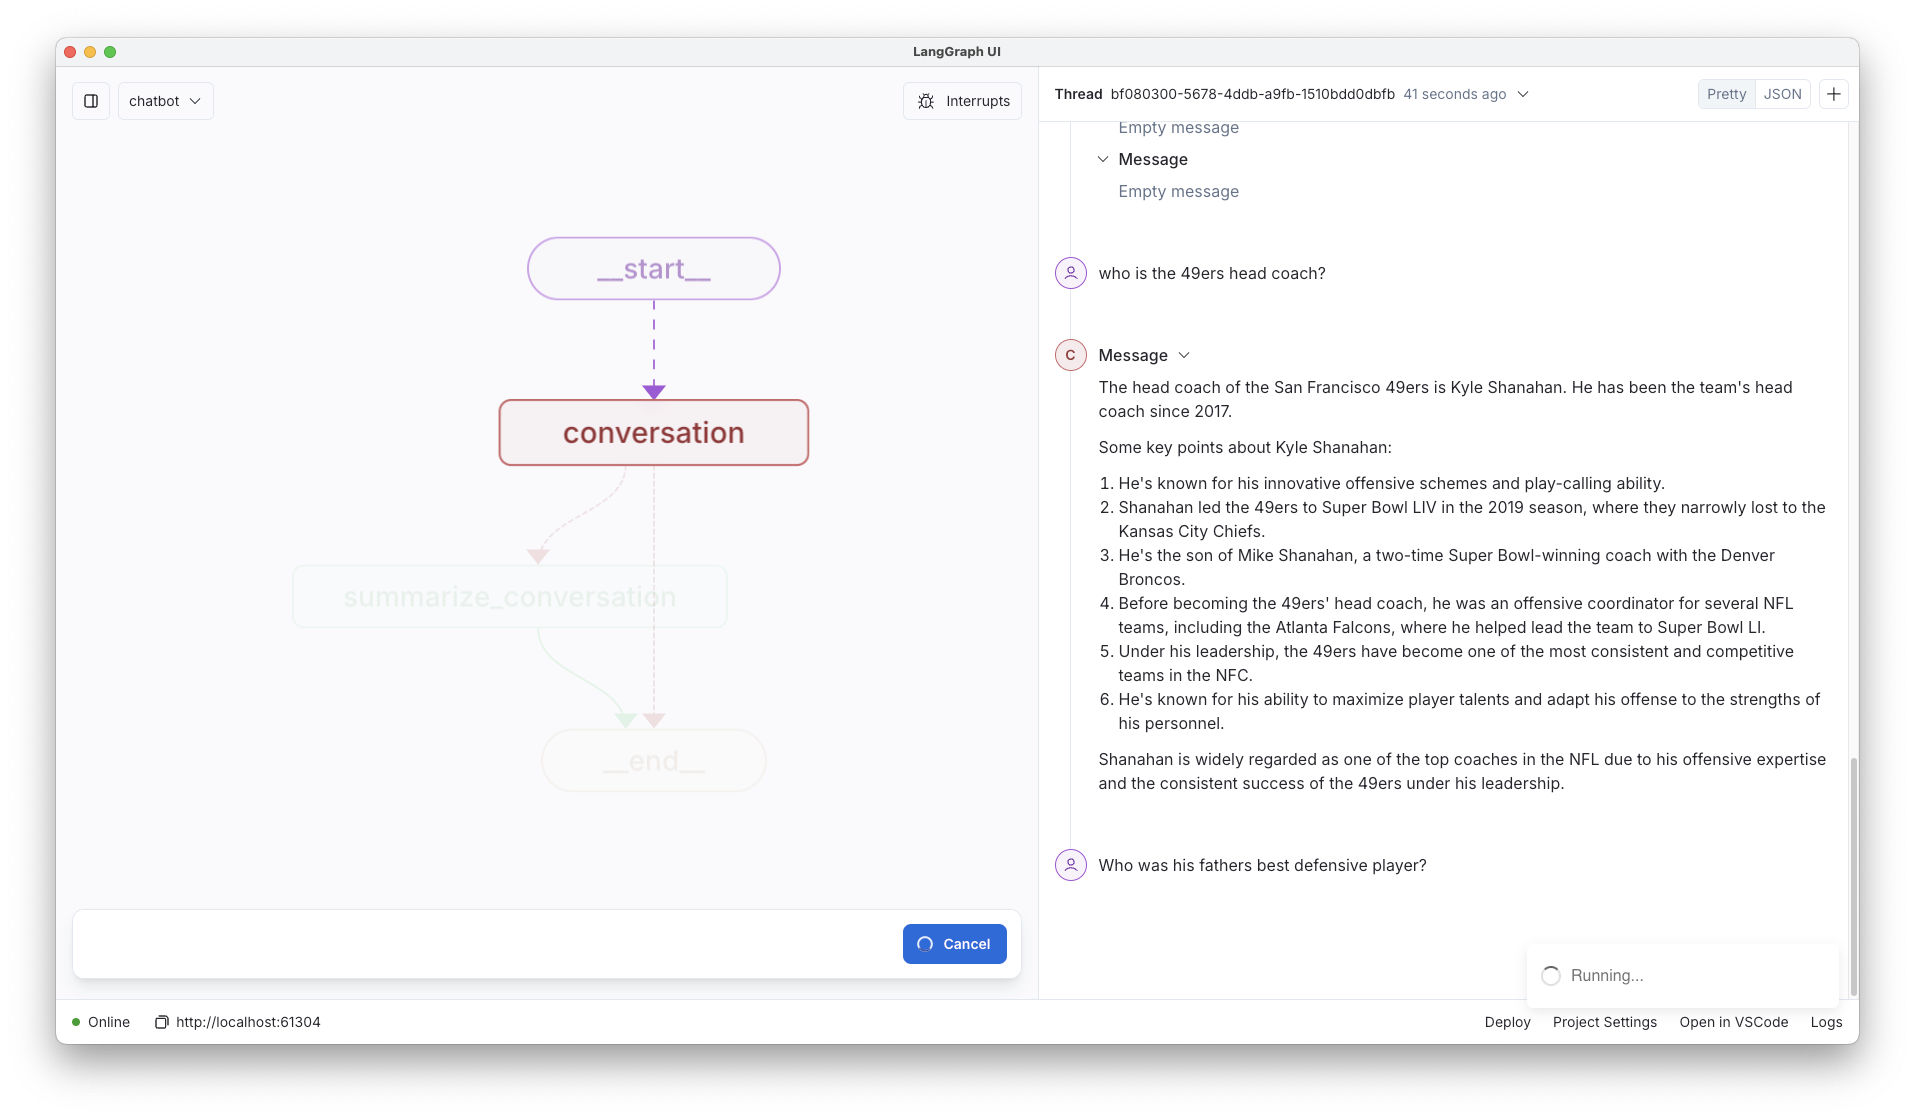

## Lesson 2: Breakpoints

Above, we showed the rather crude process of stopping graph execution, and resuming from our last saved checkpoint.

As mentioned, this is a simple Human-in-the-loop (HIL) interaction! 

These interactions are crucial for many agentic systems. 

[Breakpoints](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage) give us a way to formalize this process, stopping the graph at a specific step. 

One of the most common use-cases for this with agents is tool-use-approval.

For example, many tools (e.g., database actions, writing to external systems) may be sensitive and require human approval before execution.

Let's consider the agent that we worked with previously. 
 
But, we'll compile the graph with `interrupt_before=["tools"]`. 

This means that the execution will be interrupted before the node `tools`, which executes the tool call.

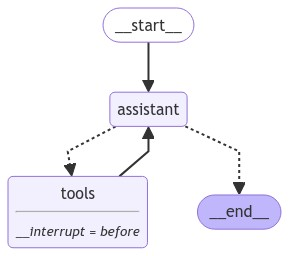

In [7]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

from IPython.display import Image, display

from langchain_openai import ChatOpenAI

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def multiply(a: int, b: int) -> int:
    """Multiplies a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

# State
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Assistant
class Assistant:
    def __init__(self, runnable: Runnable):
        """
        Initialize the Assistant with a runnable object.
        """
        self.runnable = runnable

    def __call__(self, state: MessagesState, config: RunnableConfig):
        """
        Call method to invoke
        """
        result = self.runnable.invoke(state)  
        return {"messages": result}

# Assistant prompt
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            " You are a helpful assistant tasked with writing performing arithmatic on a set of inputs. "
         ),
        ("placeholder", "{messages}"),
    ]
)

# Prompt our LLM and bind tools
llm = ChatOpenAI(model="gpt-4o")
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"],checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can see that the agent proceeds until it hits the `tools` node.

In [8]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
events = graph.stream(initial_input, thread, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_o0OfhkL99im9R86CJxIVTgzT)
 Call ID: call_o0OfhkL99im9R86CJxIVTgzT
  Args:
    a: 2
    b: 3


Now, we'll introduce a nice trick.

When we invoke the graph with `None`, it will continue from the prior checkpoint!

In [9]:
events = graph.stream(None, thread, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


Now, we can simply bring these two pieces together with an explict user approval step.

```
user_approval = input("Do you want to call the tool? (yes/no): ")
```

If the user supplies, `yes` then the graph will proceed.

In [11]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
events = graph.stream(initial_input, thread, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

# Check approval
user_approval = input("Do you want to call the tool? (yes/no): ")

if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    events = graph.stream(None, thread, stream_mode="values")
    for event in events:
        event["messages"][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_r3ck6ES7wsEayGORq9mkExj2)
 Call ID: call_r3ck6ES7wsEayGORq9mkExj2
  Args:
    a: 2
    b: 3


Do you want to call the tool? (yes/no):  yes


================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


We do do the [same in Studio](https://github.com/langchain-ai/langgraph-studio?tab=readme-ov-file#human-in-the-loop)! 

But, in this case we only need to supply the breakpoint.

We can perform the approval step in Studio directly, as noted with `Continue`.

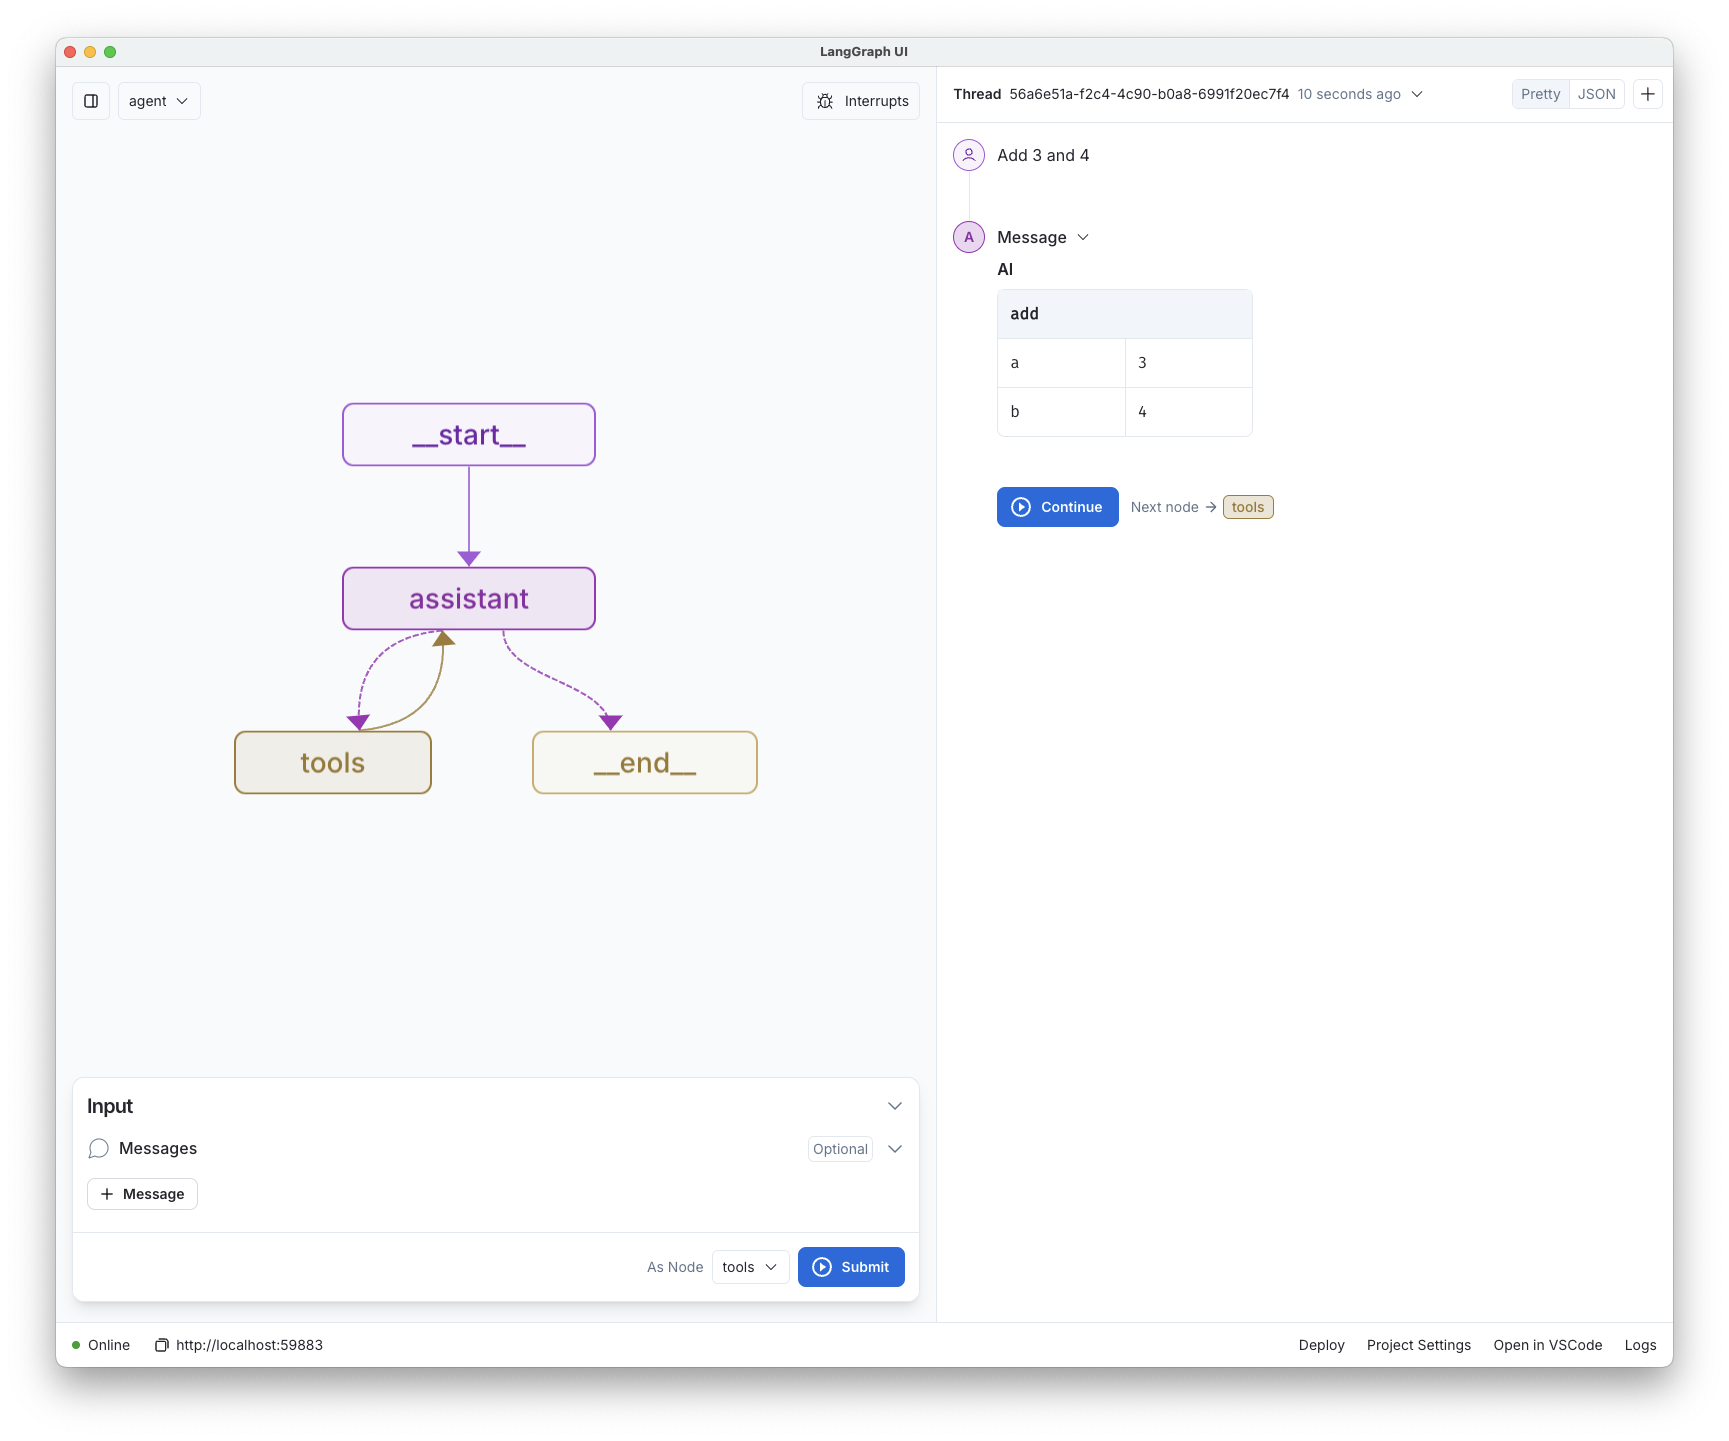

### Lesson 2: Human Feedback and Editing Graph State

We can also allow for human feedback to be inserted into our graph execution.

Here, [we create a node](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/) for accepting the human feedback.

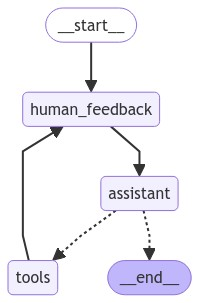

In [12]:
# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "3"}}

# Run the graph until the first interruption
events = graph.stream(initial_input, thread, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()
    
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
events = graph.stream(None, thread, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


Tell me how you want to update the state:  Actually, let's multiple 3 and 3. 


================================== Ai Message ==================================
Tool Calls:
  multiply (call_AdBsAPIILZOvUZ4d62qLXg9l)
 Call ID: call_AdBsAPIILZOvUZ4d62qLXg9l
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [16]:
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
events = graph.stream(None, thread, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

Tell me how you want to update the state:  Correct! Let's summarize what you did and return it.


================================== Ai Message ==================================

Sure! I performed the multiplication of 3 and 3, which resulted in 9.


With Studio, we can achieve this same result! 

All we need to do is simply edit the state at any breakpoint.

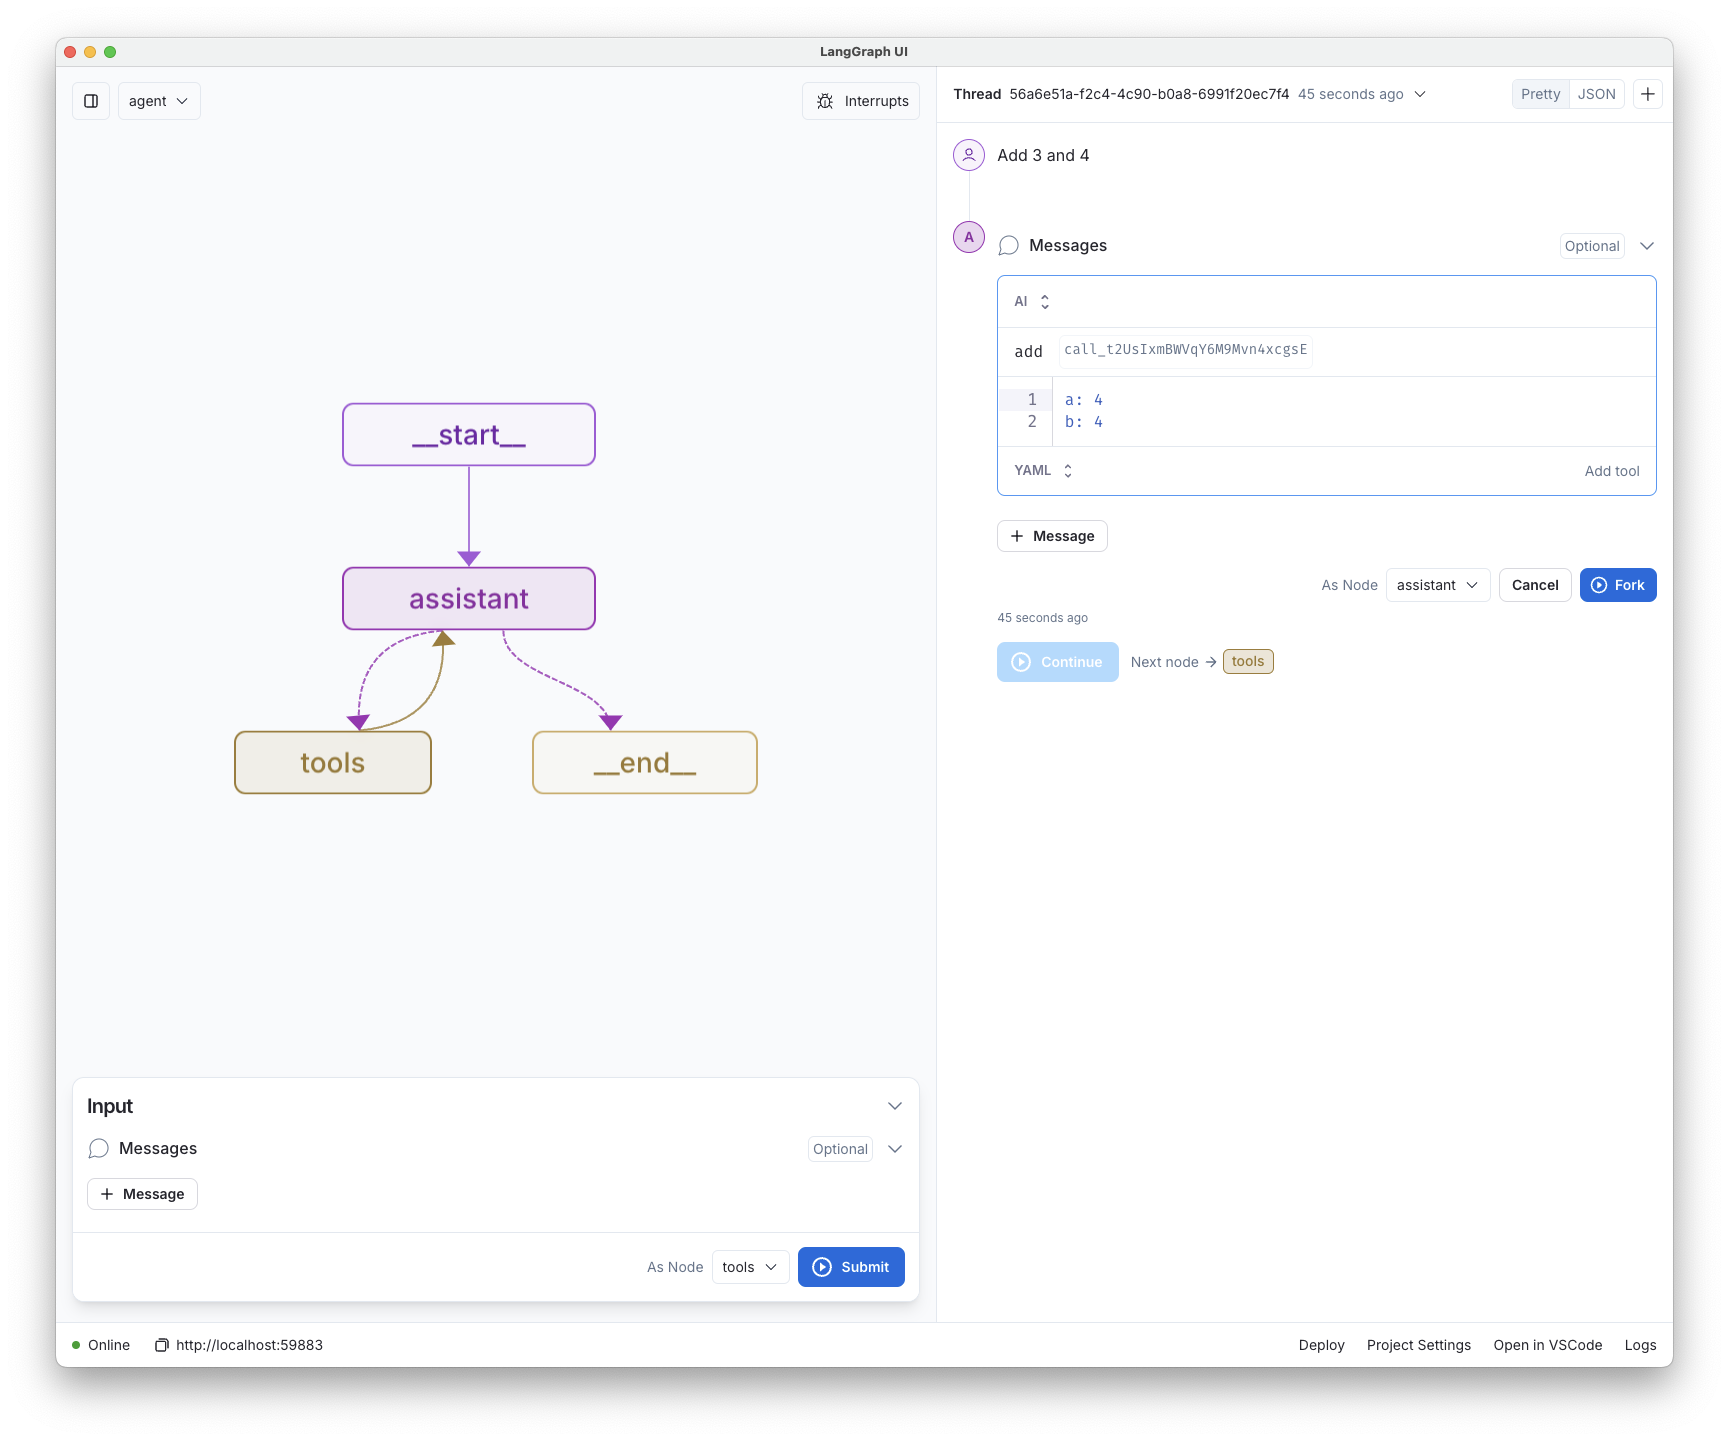